In [1]:
# !pip install tensorflow
# !pip install keras

from keras.layers import BatchNormalization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D  # convolution layers
from keras.layers import Dense, Dropout, Flatten  # core layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
df = pd.read_csv("digit.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Separate features and labels
x = train.drop(['label'], 1).values
y = train['label'].values

C:\Users\pooja\AppData\Local\Temp\ipykernel_13944\637812223.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = train.drop(['label'], 1).values


In [4]:
# Grayscale normalization
x = x / 255.0

In [5]:
# Reshape the image
x = x.reshape(-1, 28, 28, 1)

In [6]:
# Label encoding
y = to_categorical(y)

In [7]:
# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

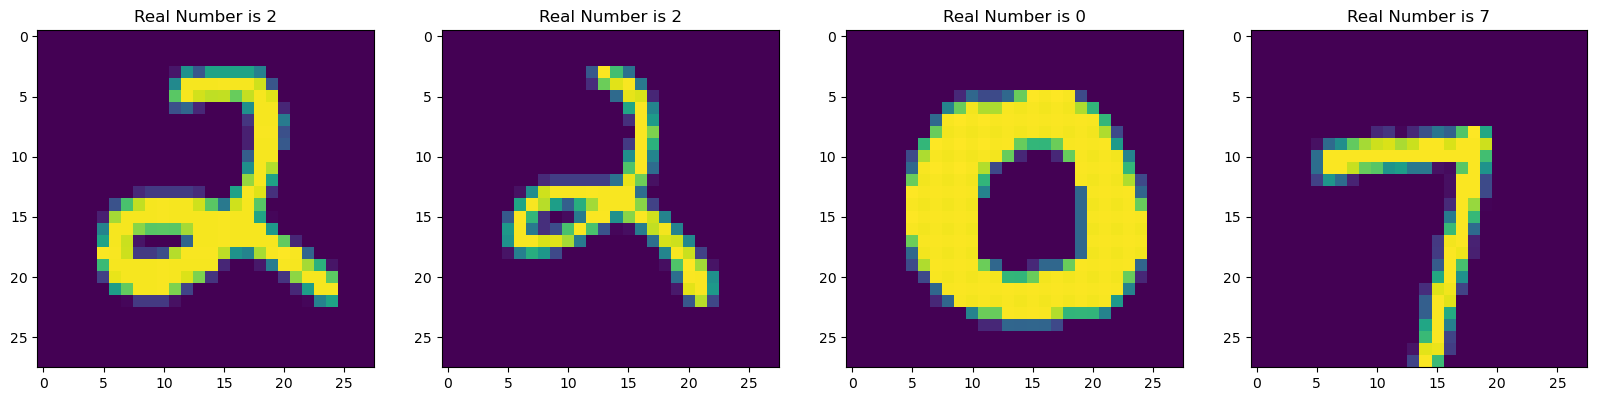

In [8]:
# Visualize some training samples
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)
fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='viridis')
    digit = y_train[i].argmax()
    ax.set(title=f"Real Number is {digit}")
plt.show()

In [9]:
# Calculate mean and standard deviation for data standardization
mean = np.mean(X_train)
std = np.std(X_train)

In [10]:
def standardize(x):
    return (x - mean) / std

In [11]:
# Create the model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [12]:
# Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        zoom_range=0.01,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

epochs = 100
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

In [13]:
# Define callbacks for early stopping and learning rate reduction
es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True)

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001)

# Fit the model
history = model.fit(train_gen,
                    epochs=epochs,
                    steps_per_epoch=train_steps,
                    validation_data=test_gen,
                    validation_steps=valid_steps,
                    callbacks=[es, rp])


Epoch 1/100
295/295 [==============================] - 154s 517ms/step - loss: 0.1585 - accuracy: 0.9495 - val_loss: 1.6386 - val_accuracy: 0.3567 - lr: 0.0010
Epoch 2/100
295/295 [==============================] - 163s 551ms/step - loss: 0.0658 - accuracy: 0.9801 - val_loss: 0.2091 - val_accuracy: 0.9302 - lr: 0.0010
Epoch 3/100
295/295 [==============================] - 167s 565ms/step - loss: 0.0492 - accuracy: 0.9848 - val_loss: 0.0767 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 4/100
295/295 [==============================] - 194s 658ms/step - loss: 0.0445 - accuracy: 0.9865 - val_loss: 0.0590 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 5/100
295/295 [==============================] - 182s 617ms/step - loss: 0.0350 - accuracy: 0.9892 - val_loss: 0.0529 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 6/100
295/295 [==============================] - 189s 640ms/step - loss: 0.0357 - accuracy: 0.9889 - val_loss: 0.0637 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 7/100
295/295 [===================

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='CNN_model_arch.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


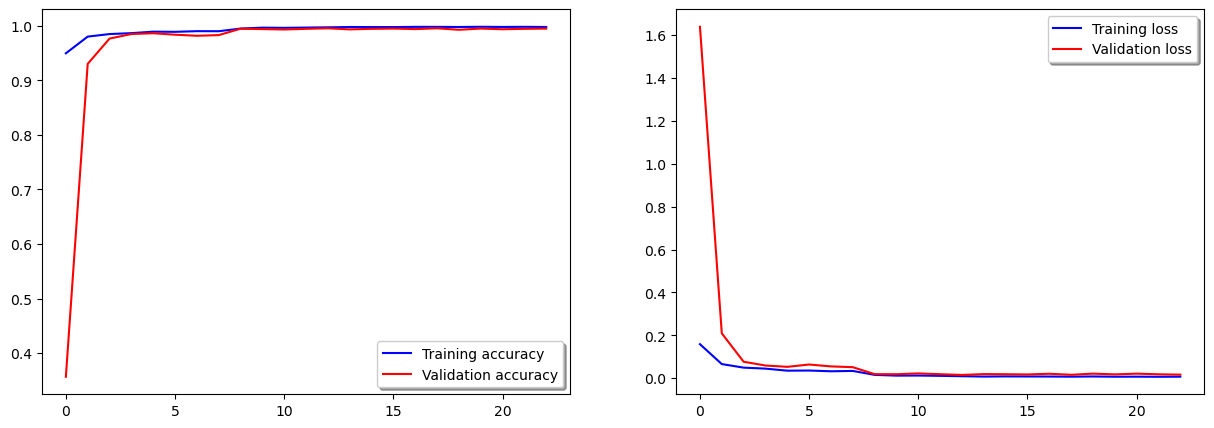

In [15]:
import matplotlib.pyplot as plt

# Plotting accuracy
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

# Plotting loss
ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="Validation loss")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()


132/132 [==============================] - 5s 34ms/step


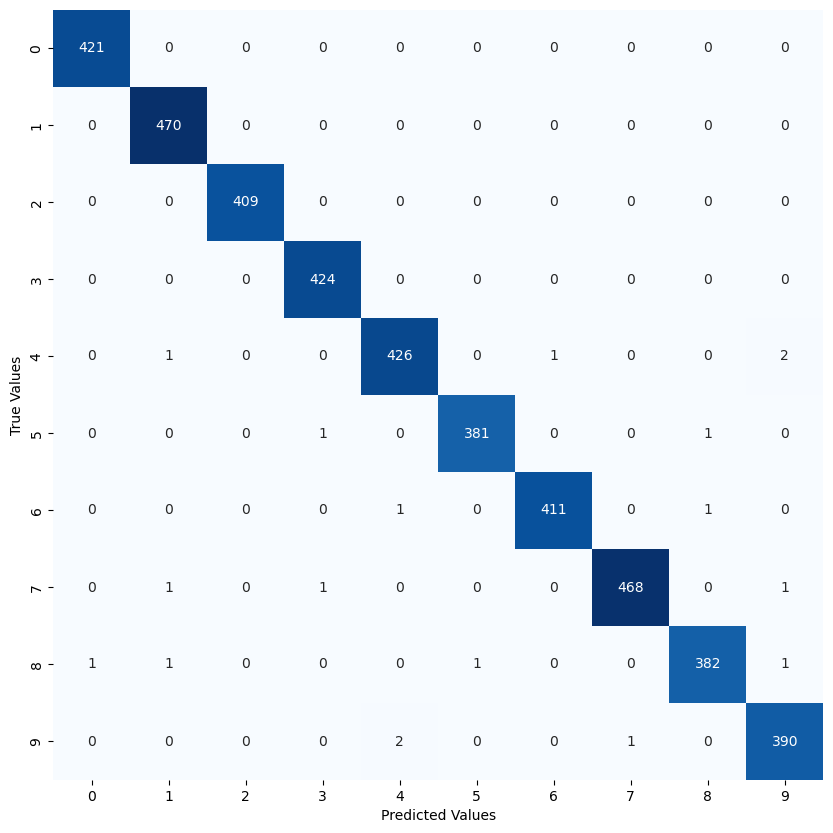

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to class labels
y_pred = model.predict(X_test)
Y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_test, axis=1)

# Create confusion matrix
mat = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix
fig = plt.figure(figsize=(10, 10))
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()


132/132 [==============================] - 4s 32ms/step


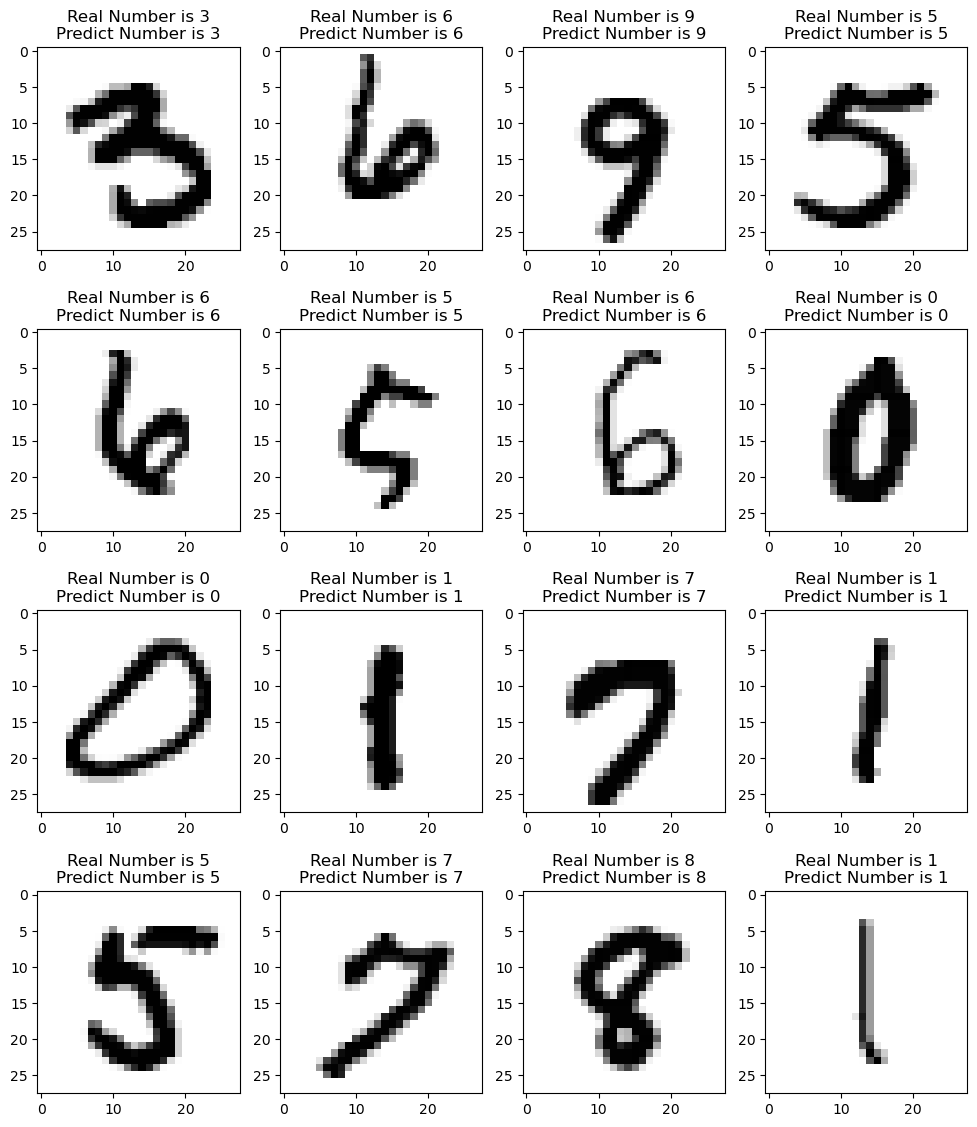

In [17]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

In [19]:
# submissions
import pandas as pd

# Create a DataFrame for submission
sub = pd.DataFrame()
sub['Label'] = pred

# Save the DataFrame to a CSV file
sub.to_csv("CNN_keras_sub.csv", index=False)

# Display the first few rows of the DataFrame
sub.head()

,Label
0,2
1,0
2,9
3,0
4,3
